<a href="https://colab.research.google.com/github/shivaansh81001/btc-prediction/blob/main/btc_data_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [57]:
path='sample_data/'

In [58]:
TABLE_NAME='btcusd_1-min_data.csv'
data=Table().read_table(path+TABLE_NAME)
data.show(5)

Timestamp,Open,High,Low,Close,Volume
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0


In [59]:
data= data.where("Timestamp",are.above_or_equal_to(1636520280))
data.show(5)

Timestamp,Open,High,Low,Close,Volume
1.63652e+09,66991.5,66991.5,66935.9,66935.9,2.06704
1.63652e+09,66937.1,66945.7,66927.5,66945.7,0.130802
1.63652e+09,66928.4,66988.9,66928.4,66972.1,0.031246
1.63652e+09,66995.5,67014.5,66995.5,67014.5,0.0697985
1.63652e+09,67018.2,67123.4,67007.5,67123.4,1.64906


In [60]:
def format_price(price):
  split_=price.split(',')
  return float(split_[0]+split_[1])

def format_vol(vol):
  split_=float(vol[:-1])*1000
  return split_

def format_change(change):
  return float(change[:-1])

def format_time(time):
  time=int(time)
  return str(datetime.utcfromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S'))

In [61]:
#test format_price
print(format_price('95,284.5'))

#test format_vol
print(format_vol('61.62K'))

#test format_time
print(format_time(1734447660))

95284.5
61620.0
2024-12-17 15:01:00


In [62]:
formatted_time = data.apply(format_time,"Timestamp")
data = data.with_column("Timestamp",formatted_time)

data.show(5)

Timestamp,Open,High,Low,Close,Volume
2021-11-10 04:58:00,66991.5,66991.5,66935.9,66935.9,2.06704
2021-11-10 04:59:00,66937.1,66945.7,66927.5,66945.7,0.130802
2021-11-10 05:00:00,66928.4,66988.9,66928.4,66972.1,0.031246
2021-11-10 05:01:00,66995.5,67014.5,66995.5,67014.5,0.0697985
2021-11-10 05:02:00,67018.2,67123.4,67007.5,67123.4,1.64906


In [63]:
'''%matplotlib inline

data.plot("Date","Price")

data.plot("Date","Change %")

data.scatter('Date',"Price")'''


'%matplotlib inline\n\ndata.plot("Date","Price")\n\ndata.plot("Date","Change %")\n\ndata.scatter(\'Date\',"Price")'

In [64]:
news= Table.read_table(path+'cryptonews.csv').drop('url','source')
news = news.where("subject",are.equal_to("bitcoin"))
news.show(100)


date,sentiment,subject,text,title
2023-12-19 05:25:00,"{'class': 'negative', 'polarity': -0.01, 'subjectivity': ...",bitcoin,"Yonsei found that during BTC’s rally in early December, ...",Is This Why Bitcoin’s Price Rally Was Halted? (CryptoQuant)
2023-12-19 04:50:11,"{'class': 'positive', 'polarity': 0.3, 'subjectivity': 0.1}",bitcoin,"Cathie Wood led ARK Invest fund sold around 809, 441 Gra ...",Cathie Wood’s Ark Invest Sells $27.6 Million in GBTC Sha ...
2023-12-19 04:10:00,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,Bitcoin's 150% surge pales in comparison to the staggeri ...,Bitcoin Soared 150% in 2023 But These Companies Did Even ...
2023-12-19 02:59:59,"{'class': 'negative', 'polarity': -0.08, 'subjectivity': ...",bitcoin,The SEC has pushed back its decision on a roster of Ethe ...,"SEC delays several Ethereum ETFs, pushing final decision ..."
2023-12-18 18:33:34,"{'class': 'negative', 'polarity': -0.27, 'subjectivity': ...",bitcoin,"Bitcoin may remain under pressure for a few days, but a ...","Price analysis 12/18: SPX, DXY, BTC, ETH, BNB, XRP, SOL, ..."
2023-12-18 18:15:45,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,The ad spot came as the U.S. Securities and Exchange Com ...,Bitwise launches crypto ETF media campaign with ‘The Mos ...
2023-12-18 18:11:43,"{'class': 'positive', 'polarity': 0.3, 'subjectivity': 0.45}",bitcoin,"Bitcoin (BTC), the world's most valuable cryptocurrency, ...",Bitcoin Price Prediction as VanEck’s CEO Says BTC Will H ...
2023-12-18 17:55:00,"{'class': 'positive', 'polarity': 0.2, 'subjectivity': 0.7}",bitcoin,"Since the famous meme post to BitcoinTalk, Bitcoin (BTC) ...",Bitcoiners Celebrate 10th Anniversary Of ‘HODL’ Meme
2023-12-18 17:01:00,"{'class': 'positive', 'polarity': 0.05, 'subjectivity': ...",bitcoin,"CoinShares said the ""mixed regional flows"" are more indi ...",Bitcoin Ends 11-Week Winning Streak With $33M Outflows W ...
2023-12-18 15:42:27,"{'class': 'negative', 'polarity': -0.1, 'subjectivity': 0.2}",bitcoin,Digital asset mining firm Hut 8 signed an interim agreem ...,Bitcoin Miner Hut 8 to Build Out Mining Facility in Part ...


In [65]:
#test cell for sentiment
print(news.take(0).column("text")[0])

news.sort("date",descending=False).show(3)

Yonsei found that during BTC’s rally in early December, the Binary CDD was also active, signaling recent activity by short-term holders.


date,sentiment,subject,text,title
2021-11-10 04:58:00,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,"Bitcoin price is correcting gains below USD 67,000. Ethe ...","Bitcoin and Ethereum Correct Gains, Major Altcoins Turn Red"
2021-11-10 11:09:00,"{'class': 'negative', 'polarity': -0.02, 'subjectivity': ...",bitcoin,The much-awaited wallet is scheduled to be launched late ...,Robinhood Crypto Wallet Waitlist Attracts 1.6M People
2021-11-10 13:10:00,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,Bitcoin price is struggling to gain momentum for a move ...,Bitcoin and Ethereum Prepare For Next Move


In [66]:
print(type(news.column("date").take(0)))

<class 'numpy.str_'>


In [67]:
def date_fix(date):
  return date[:-2]+'00'

In [68]:
#test date_fix
print(date_fix('2021-11-10 13:10:11'))

2021-11-10 13:10:00


In [69]:
class_ = []
polarity_ = []
subjectivity_ = []

for row in news.column("sentiment"):
  row=eval(row)
  if row['class']=='neutral':
    class_.append(0)
  elif row['class']=='negative':
    class_.append(-1)
  elif row['class']=='positive':
    class_.append(1)


  polarity_.append(row['polarity'])
  subjectivity_.append(row['subjectivity'])

class_,polarity_,subjectivity_=map(np.array,(class_,polarity_,subjectivity_))
print(class_,polarity_,subjectivity_)

fixed_date = news.apply(date_fix,'date')


news = news.with_columns("class",class_,"polarity",polarity_,"subjectivity",subjectivity_,"date",fixed_date).drop('sentiment')

news.sort("date",descending=True).show(5)



[-1  1  0 ...,  0 -1  0] [-0.01  0.3   0.   ...,  0.   -0.02  0.  ] [ 0.38  0.1   0.   ...,  0.    0.47  0.  ]


date,subject,text,title,class,polarity,subjectivity
2023-12-19 05:25:00,bitcoin,"Yonsei found that during BTC’s rally in early December, ...",Is This Why Bitcoin’s Price Rally Was Halted? (CryptoQuant),-1,-0.01,0.38
2023-12-19 04:50:00,bitcoin,"Cathie Wood led ARK Invest fund sold around 809, 441 Gra ...",Cathie Wood’s Ark Invest Sells $27.6 Million in GBTC Sha ...,1,0.3,0.1
2023-12-19 04:10:00,bitcoin,Bitcoin's 150% surge pales in comparison to the staggeri ...,Bitcoin Soared 150% in 2023 But These Companies Did Even ...,0,0,0
2023-12-19 02:59:00,bitcoin,The SEC has pushed back its decision on a roster of Ethe ...,"SEC delays several Ethereum ETFs, pushing final decision ...",-1,-0.08,0.64
2023-12-18 18:33:00,bitcoin,"Bitcoin may remain under pressure for a few days, but a ...","Price analysis 12/18: SPX, DXY, BTC, ETH, BNB, XRP, SOL, ...",-1,-0.27,0.33


In [70]:
merged_table = news.join("date",data,"Timestamp")
merged_table.show(5)

date,subject,text,title,class,polarity,subjectivity,Open,High,Low,Close,Volume
2021-11-10 04:58:00,bitcoin,"Bitcoin price is correcting gains below USD 67,000. Ethe ...","Bitcoin and Ethereum Correct Gains, Major Altcoins Turn Red",0,0,0,66991.5,66991.5,66935.9,66935.9,2.06704
2021-11-10 11:09:00,bitcoin,The much-awaited wallet is scheduled to be launched late ...,Robinhood Crypto Wallet Waitlist Attracts 1.6M People,-1,-0.02,0.47,66540.2,66540.2,66540.2,66540.2,0.00301
2021-11-10 13:10:00,bitcoin,Bitcoin price is struggling to gain momentum for a move ...,Bitcoin and Ethereum Prepare For Next Move,0,0,0,66496.7,66517.3,66496.7,66517.3,0.192173
2021-11-10 15:37:00,bitcoin,Bitcoin (BTC) hit yet another all-time high on Wednesday,Bitcoin Hits All-Time High on Record US Inflation Figures,1,0.16,0.54,66840.1,66852.4,66832.9,66836.5,0.43763
2021-11-11 09:07:00,bitcoin,The latest announcement appears part of a coordinated an ...,Twitter Launches Twitter Crypto: Here's How the Company ...,1,0.38,0.57,64708.8,64825.7,64708.8,64825.7,2.24765


In [71]:
merged_table = merged_table.drop('bitcoin','text','title','subject')


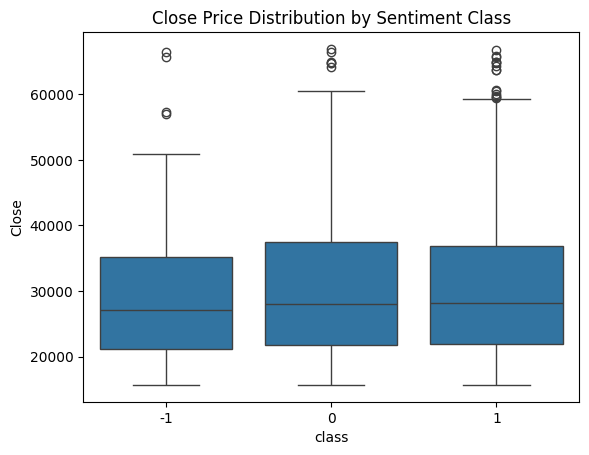

In [72]:
%matplotlib inline
import seaborn as sns

df= merged_table.to_df()
sns.boxplot(x='class', y='Close', data=df)
plt.title('Close Price Distribution by Sentiment Class')
plt.show()

In [73]:
downsample_rate = 50
date=df['date'][::downsample_rate]
polarity=df['polarity'][::downsample_rate]
close=df['Close'][::downsample_rate]

<function matplotlib.pyplot.show(close=None, block=None)>

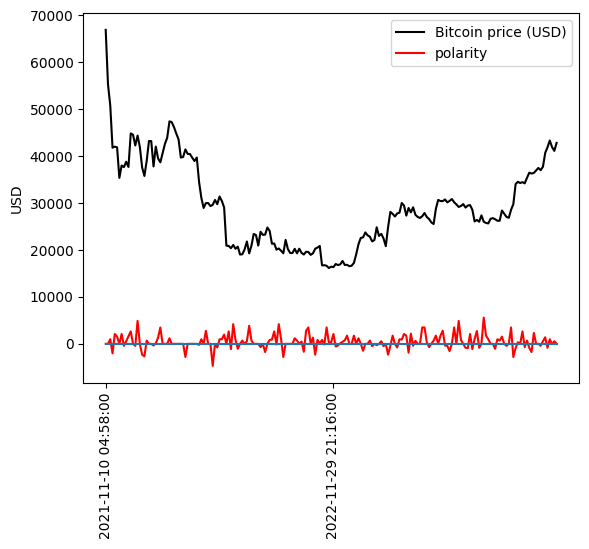

In [74]:
plt.figure()
plt.plot(date,close,'k',label = 'Bitcoin price (USD)')
plt.plot(date,7000*polarity,'r',label = 'polarity')
plt.plot(date,np.zeros(len(date)))
plt.ylabel('USD')
plt.xticks(date[::100],rotation='vertical')
plt.legend()
plt.show

In [75]:
from scipy.stats import f_oneway

negative = df[df['class'] == -1]['Close']
neutral = df[df['class'] == 0]['Close']
positive = df[df['class'] == 1]['Close']

stat, p_value = f_oneway(negative, neutral, positive)

print(f"ANOVA Statistic: {stat}, p-value: {p_value}")
if p_value < 0.05:
    print("Significant difference in Close Price across sentiment classes.")
else:
    print("No significant difference in Close Price across sentiment classes.")

ANOVA Statistic: 12.87223102616396, p-value: 2.6114620415262533e-06
Significant difference in Close Price across sentiment classes.
